Trening SARSA: 100%|██████████| 200000/200000 [00:02<00:00, 92225.07it/s]



REZULTATI NAKON 200000 EPIZODA:
Q-Learning Win Rate: 41.03%
SARSA Win Rate:      41.26%
ZAKLJUČAK: SARSA je postigao bolji rezultat u ovoj simulaciji (On-policy).


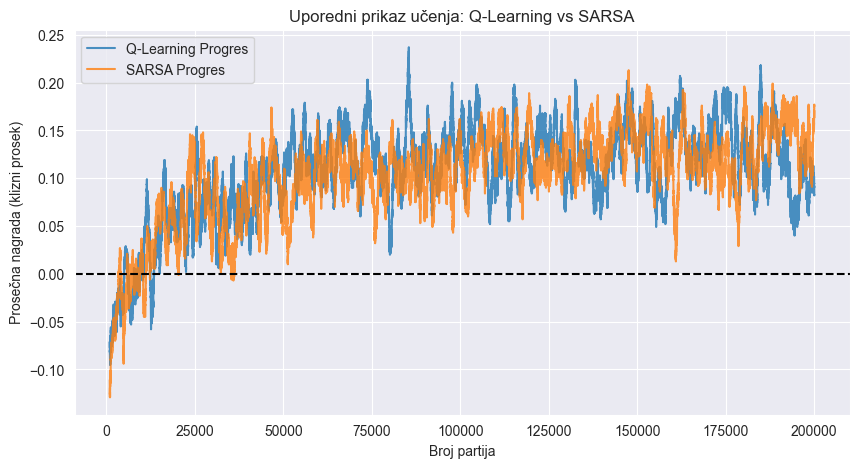

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from random import random, choice
from tqdm import trange

# QL I SARSA ALGORITAM BLACKJACK

# -- postavka --

class Action(Enum):
    HIT = 0
    HOLD = 1

class BlackjackEnv:
    def __init__(self):
        # 2-9 su brojevi, 10, J, Q, K su 10, Ace je 11
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4  # ovim definisemo spil od 52 karte,
        # mnozenje sa 4 jer od svake karte imamo po 4 znaka

    def draw_card(self):
        return choice(self.deck)

    def get_score(self, hand):
        score = sum(hand)
        usable_ace = 11 in hand and score <= 21 # logika za soft ruku (soft ruka je bezbedan nacin da i ako imam ace da se on moze racunati i kao 1 ako izvucem posle jacu kartu i da ne dodje do prekoracenja)
        if score > 21 and 11 in hand: # ako smo probili 21, a imamo keca (11), smanjujemo mu vrednost na 1
            hand[hand.index(11)] = 1
            return self.get_score(hand)
        return score, usable_ace

    def play_dealer(self, dealer_hand):
        #fiksna politika iz sveske: Dealer HIT do 17
        score, _ = self.get_score(dealer_hand)
        while score < 17:
            dealer_hand.append(self.draw_card())
            score, _ = self.get_score(dealer_hand)
        return score

# -- agent (impelemntacija QL i SARSE) --

class Agent:
    def __init__(self, alpha=0.01, gamma=1.0, epsilon=1.0):
        self.q_table = {} #memorija cuvanja q vrednosti za stanja
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = 0.9999
        self.min_epsilon = 0.05 #vremenom se smanjuje nasumicnost (epsilon_decay se smanjuje) i pocinje vise da koristi nauceno znanje, ali ipak zadrzavamo 5% slucajnih poteza kkao bi nastavio da uci

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0) #fja vraca 0 kao pocetnu prepostavku ako nije nikad bio u nekom stanju

    def choose_action(self, state):
        if random() < self.epsilon: #ako je generisan broj manji od espilona ulazi se u fazu istrazivanja
            return choice(list(Action))
        q_hit = self.get_q(state, Action.HIT) #bot gleda u svoju Q-tabelu kolika je ocekivana nagrada ako izabere HIT u trenutnom stanju
        q_hold = self.get_q(state, Action.HOLD) #isto to samo za HOLD
        return Action.HIT if q_hit > q_hold else Action.HOLD

# -- trening --

def train(method="QL", episodes=100000):
    env = BlackjackEnv()
    agent = Agent()
    history = []

    for _ in trange(episodes, desc=f"Trening {method}"):
        p_hand = [env.draw_card(), env.draw_card()]
        d_hand = [env.draw_card()]
        done = False
        reward = 0

        while not done:
            score, usable_ace = env.get_score(p_hand)
            state = (score, d_hand[0], usable_ace) #stanje iz sveske

            if score > 21: #player busted: r = -1
                reward = -1
                agent.q_table[(state, Action.HIT)] = agent.get_q(state, Action.HIT) + \
                    agent.alpha * (reward - agent.get_q(state, Action.HIT))
                done = True
                break

            action = agent.choose_action(state)

            if action == Action.HOLD:
                d_score = env.play_dealer(d_hand)
                #ishodi igre
                if d_score > 21 or score > d_score: reward = 1
                elif score < d_score: reward = -1
                else: reward = 0

                agent.q_table[(state, action)] = agent.get_q(state, action) + \
                    agent.alpha * (reward - agent.get_q(state, action))
                done = True
            else:
                p_hand.append(env.draw_card())
                n_score, n_ace = env.get_score(p_hand)
                n_state = (n_score, d_hand[0], n_ace)

                if n_score > 21:
                    target = -1
                    done = True
                else:
                    if method == "QL":
                        #Off-policy: Max Q
                        target = agent.gamma * max(agent.get_q(n_state, Action.HIT),
                                                 agent.get_q(n_state, Action.HOLD))
                    else:
                        #On-policy: SARSA
                        n_act = agent.choose_action(n_state)
                        target = agent.gamma * agent.get_q(n_state, n_act)

                agent.q_table[(state, action)] = agent.get_q(state, action) + \
                    agent.alpha * (target - agent.get_q(state, action))

        agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)
        history.append(reward)
    return agent, history

#proces treninga pocinje simulacijom hiljada partija gde se u svakom koraku prati stanje definisano tripletom (score, d_hand[0], usable_ace), dok agent pokusava da kroz akcije HIT/HOLD maksimizuje svoju nagradu. Unutar petlje, if uslov odmah proverava da li je igrac premasio 21, pri cemu odmah belezi poraz (r = -1), dok else grana omogucava agentu da, ukoliko nije "izgoreo", donese odluku koristeći epsilon -greedy strategiju. Ako agent izabere HOLD, prepusta igru fiksnoj politici deljenika i na kraju uporeduje rezultate da bi upisao konačnu nagradu, ali ako izabere HIT, nastupa kljucna razlika u ucenju: Q-Learning gleda isključivo maksimalnu mogucu vrednost sledeceg stanja (Max Q) ne mareci za buduce greske, dok SARSA  bira sledeću akciju i uči na osnovu te konkretne, planirane putanje

# -- poredjenje --

N = 200000
ql_agent, ql_res = train("QL", N)
sarsa_agent, sarsa_res = train("SARSA", N)

ql_win_rate = (ql_res.count(1) / N) * 100
sarsa_win_rate = (sarsa_res.count(1) / N) * 100

print("\n" + "="*40)
print(f"REZULTATI NAKON {N} EPIZODA:")
print(f"Q-Learning Win Rate: {ql_win_rate:.2f}%")
print(f"SARSA Win Rate:      {sarsa_win_rate:.2f}%")
print("="*40)

if ql_win_rate > sarsa_win_rate:
    print("ZAKLJUČAK: Q-Learning je BOLJI jer je efikasnije pronašao optimalnu politiku (Off-policy).")
else:
    print("ZAKLJUČAK: SARSA je postigao bolji rezultat u ovoj simulaciji (On-policy).")

# grafik poređenja progresije
plt.figure(figsize=(10, 5))
plt.plot(pd.Series(ql_res).rolling(1000).mean(), label="Q-Learning Progres", alpha=0.8)
plt.plot(pd.Series(sarsa_res).rolling(1000).mean(), label="SARSA Progres", alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Uporedni prikaz učenja: Q-Learning vs SARSA")
plt.xlabel("Broj partija")
plt.ylabel("Prosečna nagrada (klizni prosek)")
plt.legend()
plt.show()

### ZAKLJUCAK NA OSNOVU REZULTATA
Na osnovu 200.000 odigranih partija, vidimo da su oba bota uspesno savladala igru, ali je SARSA, sto je narandzasta linija, postigla stabilniji i bolji rezultat. Dok Q-Learning tezi teoretskom maksimumu, SARSA je kao on-policy algoritam opreznija jer uci na osnovu sopstvenih gresaka tokom izvlacenja karata, sto je u Blackjacku kljucno za izbegavanje 'bust-a'. Agenti su pravilno naucili da koriste 'soft' keca kao bezbednu zonu i da iskoriste fiksnu manu deljenika koji mora da stane na 17, cime su pretvorili pocetno lutanje u stabilnu prednost prikazanu na grafiku.

Trening QL: 100%|██████████| 100000/100000 [00:01<00:00, 88174.22it/s]


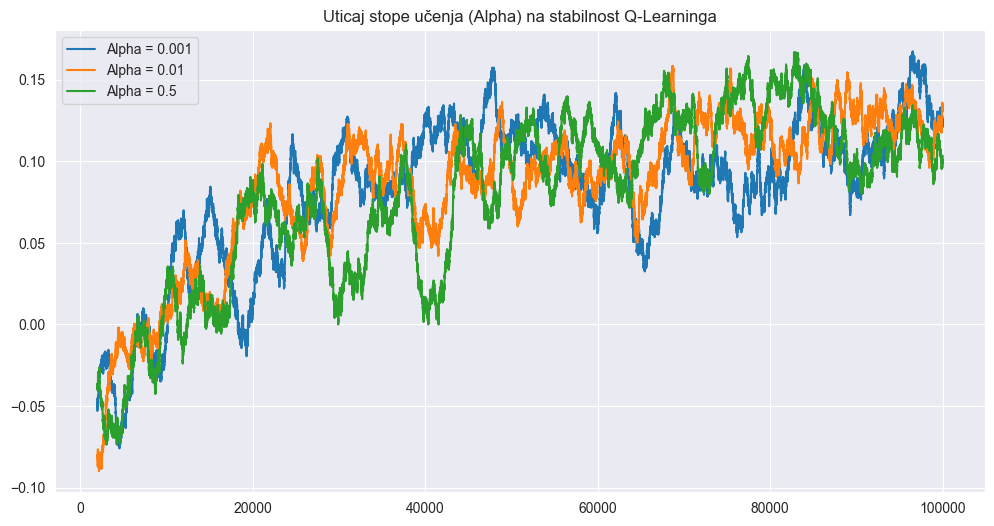

In [3]:
#Testiramo razlicite alfe za QL
alphas = [0.001, 0.01, 0.5]
plt.figure(figsize=(12, 6))

for a in alphas:
    temp_agent, temp_res = train("QL", episodes=100000)
    plt.plot(pd.Series(temp_res).rolling(2000).mean(), label=f"Alpha = {a}")

plt.title("Uticaj stope učenja (Alpha) na stabilnost Q-Learninga")
plt.legend()
plt.show()

## ZAKLJUCAK NA OSNOVU MENJANJA PARAMETRA BRZINE UCENJA QL
U ovom koraku smo testirali brzinu ucenja (alpha) kako bismo videli koliko bot treba da veruje svakoj novoj partiji. Menjali smo vrednosti alfe od veoma male (0.001) do veoma velike (0.5). Grafik nam jasno pokazuje da kada je alfa prevelika (0.5), bot postaje "nervozan" i prebrzo menja misljenje nakon svakog poraza, sto vidimo kroz velika odstupanja i nestabilnu liniju ucenja. Nasuprot tome, manja vrednost alfe (0.01) deluje kao filter koji ignorise trenutnu srecu ili maler, omogucavajući botu da postepeno i stabilno izvuce pravu statistiku. Time smo dokazali da je za igre sa puno slučajnosti kljucna umerenost: sporije, ali temeljno ucenje na kraju daje agenta koji donosi mnogo kvalitetnije i sigurnije odluke

Trening SARSA: 100%|██████████| 100000/100000 [00:01<00:00, 82276.23it/s]


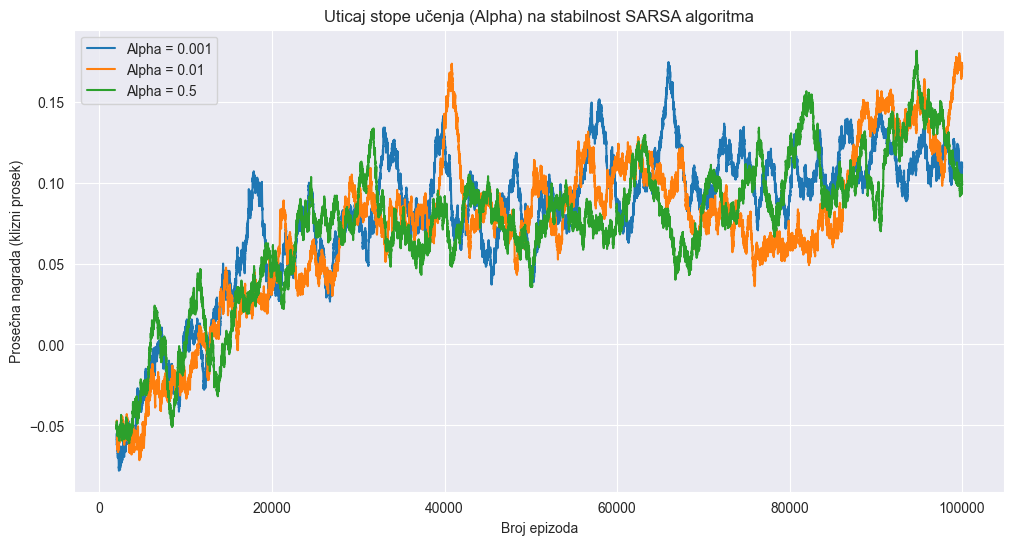

In [4]:
# Testiramo razlicite alfe za SARSA
alphas = [0.001, 0.01, 0.5]
plt.figure(figsize=(12, 6))

for a in alphas:
    # Ovde simuliramo promenu parametra (pozivamo train sa metodom SARSA)
    temp_agent, temp_res = train("SARSA", episodes=100000)
    plt.plot(pd.Series(temp_res).rolling(2000).mean(), label=f"Alpha = {a}")

plt.title("Uticaj stope učenja (Alpha) na stabilnost SARSA algoritma")
plt.xlabel("Broj epizoda")
plt.ylabel("Prosečna nagrada (klizni prosek)")
plt.legend()
plt.show()

## ZAKLJUCAK NA OSNOVU MENJANJA PARAMETARA BRZINE UCENJA SARSA
Isti test brzine ucenja (alpha) uradili smo i za SARSA algoritam, a rezultati su potvrdili da ovaj parametar igra presudnu ulogu u stabilnosti agenta. Bas kao i kod QL, prevelika alfa (0.5) cini SARSA agenta ekstremno nestabilnim: svaka slucajna greska ili losa karta odmah kvari njegovo prethodno znanje, što na grafiku vidimo kao isprekidanu i nesigurnu putanju koja ne uspeva da dostigne svoj maksimum. S druge strane, manja alfa (0.01) omogucava SARSA algoritmu da bude promisljen i da postepeno gradi svoju strategiju. Ovim smo pokazali da je za SARSU, kao oprezniji algoritam, umerena brzina ucenja kljucna kako bi agent ostao dosledan i naucio da prepozna najbolji trenutak za 'HOLD', bez obzira na kratkorocne poraze.

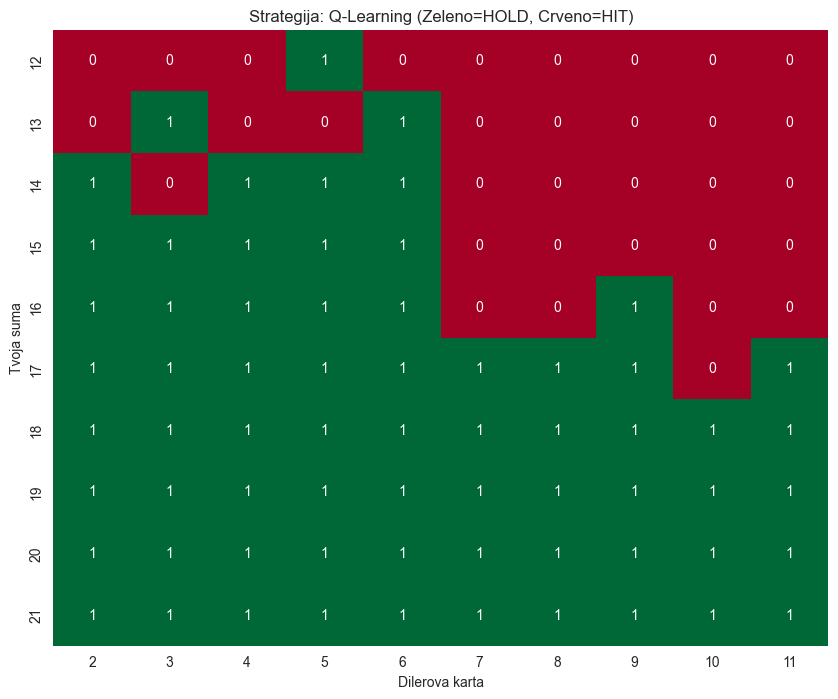

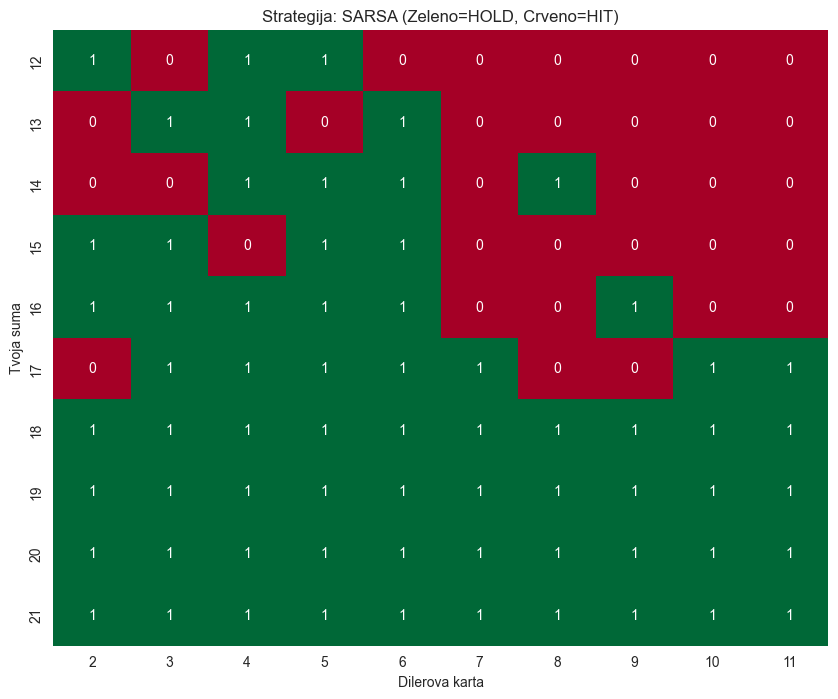

In [5]:
def plot_blackjack_policy(agent, title):
    #generisanje stanja (Suma igraca od 12 do 21, dilerova karta od 2 do 11)
    player_range = np.arange(12, 22)
    dealer_range = np.arange(2, 12)

    # Matrica za HOLD (1) ili HIT (0)
    policy_matrix = np.zeros((len(player_range), len(dealer_range)))

    for i, p_sum in enumerate(player_range):
        for j, d_card in enumerate(dealer_range):
            # Proveravamo bez keca (False)
            state = (p_sum, d_card, False)
            q_hit = agent.get_q(state, Action.HIT)
            q_hold = agent.get_q(state, Action.HOLD)
            policy_matrix[i, j] = 1 if q_hold > q_hit else 0

    plt.figure(figsize=(10, 8))
    sns.heatmap(policy_matrix, annot=True, xticklabels=dealer_range, yticklabels=player_range,
                cmap="RdYlGn", cbar=False, fmt='.0f')
    plt.title(f"Strategija: {title} (Zeleno=HOLD, Crveno=HIT)")
    plt.xlabel("Dilerova karta")
    plt.ylabel("Tvoja suma")
    plt.show()

plot_blackjack_policy(ql_agent, "Q-Learning")
plot_blackjack_policy(sarsa_agent, "SARSA")

## ZAKLJUCAK ZA QL
Na mapi se jasno vidi granica između HIT (crvena zona) i HOLD (zelena zona) odluka. Agent je naucio osnove optimalne strategije: na niskim sumama trazi kartu (HIT) kako bi se priblizio broju 21, na sumama iznad 17 staje (HOLD), prepoznajuci visok rizik od baskovanja. Agent rizikuje više kada diler pokazuje jaku kartu (10 ili as), dok igra znatno opreznije kada diler ima slabu kartu (npr. 5 ili 6), cekajući da diler sam pređe 21.

## ZAKLJUCAK ZA SARSU
Crvena zona (HIT) dominira na niskim sumama gde je rizik od gubitka minimalan, dok zelena zona (HOLD) preuzima kontrolu cim se agent priblizi kriticnoj granici od 21. Agent cesto bira sigurniju opciju i staje ranije nego što bi to uradio agresivniji bot. Buduci da SARSA uci na osnovu akcija koje planira da zaista sprovede, ona je razvila strategiju koja maksimalno smanjuje rizik od greske. Agent je naucio da pazljivo posmatra dilerovu kartu: ako diler pokazuje slabe karte (npr. 2-6), bot je veoma striktan sa zelenom bojom jer zna da je statisticki pametnije sacekati da diler sam napravi gresku.

##      FINALNI ZAKLJUCAK DOMACEG
Primenili smo Q-Learning i SARSA algoritme kako bismo resili problem donosenja odluka u okruzenju sa visokim stepenom slucajnosti, kao sto je Blackjack. Testiranjem razlicitih vrednosti stope ucenja (alpha), dokazali smo da prebrzo usvajanje informacija dovodi do nestabilnosti sistema, dok umerena alfa omogucava agentima da kroz stotine hiljada partija razviju matematicki utemeljenu strategiju. Vizuelizacijom naucenih politika (heatmap), utvrdili smo da su oba agenta samostalno identifikovala kljucna pravila igre: racionalno zaustavljanje na visokim sumama, agresivnije traženje karata kada diler ima prednost, i strpljivo cekanje dilerove greske pri njegovim slabim kartama. Finalno poredjenje pokazuje da, iako su oba pristupa efikasna, SARSA kao "on-policy" algoritam nudi stabilnije ucenje i bezbedniju strategiju, sto je u igrama sa visokim rizikom poput ove presudno za postizanje boljeg dugorocnog rezultata